In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import os 
import random 
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime 
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader,Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV


Data Extraction

In [2]:
#function that insert combined data text file into netflix rating csv file 
def load_data():
    #create new folder netflix_csv to store txt data into csv format
    netflix_csv_file = open('netflix_rating.csv',mode='w')
    rating_files = ['combined_data_2.txt']
    for file in rating_files:
        #To open the combined_data.txt file as f
        with open(file) as f:
            for line in f:
                #Remove evey space between each line 
                line = line.strip()
                if line.endswith(":"):
                    movie_id = line.replace(":","")
                else:
                    row_data = []
                    row_data = [item for item in line.split(",")]
                    row_data.insert(0,movie_id)
                    netflix_csv_file.write(",".join(row_data))
                    netflix_csv_file.write('\n')
    netflix_csv_file.close()
    df = pd.read_csv('netflix_rating.csv',sep=',',names=["movie_id","customer_id","rating","date"])
    return df



In [3]:
netflix_rating_df = load_data()
netflix_rating_df.head()




,movie_id,customer_id,rating,date
0,4500,2532865,4,2005-07-26
1,4500,573364,3,2005-06-20
2,4500,1696725,3,2004-02-27
3,4500,1253431,3,2004-03-31
4,4500,1265574,2,2003-09-01


Analysis of the data set 

In [4]:
netflix_rating_df.columns

Index(['movie_id', 'customer_id', 'rating', 'date'], dtype='object')

In [7]:
#dublicated entry
netflix_rating_df.duplicated(['movie_id', 'customer_id', 'rating', 'date']).sum()

0

In [8]:
#Split into train and test dataset 
split_value = int(len(netflix_rating_df) * 0.80)
train_data = netflix_rating_df[:split_value]
test_data = netflix_rating_df[split_value:]

In [18]:
# To find the unique vaue of each of the feature 
for features in netflix_rating_df.columns:
    print(f'The name of the feature is {features}. And the unique values are {netflix_rating_df[features].unique()}')

The name of the feature is movie_id. And the unique values are [4500 4501 4502 ... 9208 9209 9210]
The name of the feature is customer_id. And the unique values are [2532865  573364 1696725 ... 1906865 2322062 1657618]
The name of the feature is rating. And the unique values are [4 3 2 1 5]
The name of the feature is date. And the unique values are ['2005-07-26' '2005-06-20' '2004-02-27' ... '1999-12-14' '1999-12-20'
 '1999-12-15']


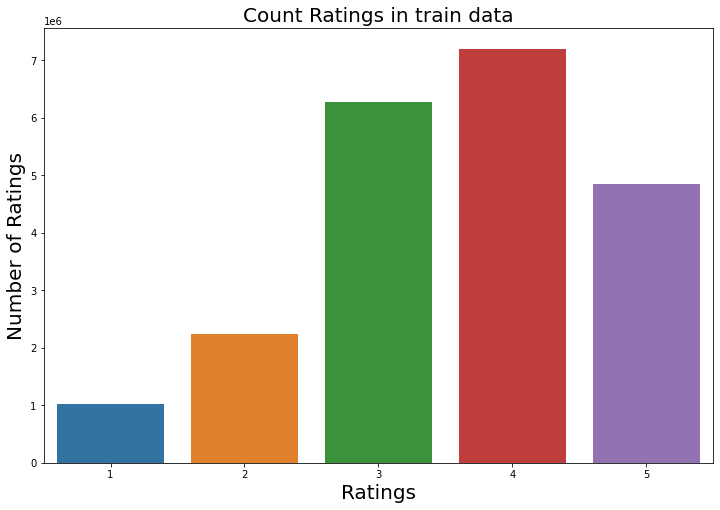

In [20]:
#Count the number of rating in the dataset 
plt.figure(figsize =(12,8))
ax = sns.countplot(x='rating',data=train_data)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [23]:
#no of rating per user 
no_of_movies_per_user = train_data.groupby(by = "customer_id")['rating'].count().sort_values(ascending=False)
no_of_movies_per_user.head(20)

customer_id
305344     3635
387418     3598
2439493    3388
1664010    3270
2118461    3053
1314869    2024
1461435    2024
1639792    2011
2606799    1862
1932594    1810
1114324    1722
2056022    1716
752642     1537
491531     1495
727242     1462
716173     1417
1473980    1409
1852040    1409
1663888    1405
798296     1401
Name: rating, dtype: int64

In [26]:
#NUmber of rating number per movie 
no_rated_movies_per_user = train_data.groupby("movie_id")["rating"].count().sort_values(ascending=False)
no_rated_movies_per_user.head(20)


movie_id
5317    232944
6287    193295
6972    171991
6037    158601
5496    155714
7624    152085
4996    151847
7234    151031
6386    148146
6206    143697
7617    141442
6134    132237
4656    130782
5862    127318
6971    126816
6692    125479
5401    122795
4640    122158
5926    121669
6844    116716
Name: rating, dtype: int64

Create User-Item Sparse Matrix

In a user-item sparse matrix, items’ values are present in the column, and users’ values are present in the rows. The rating of the user is present in the cell. Such is a sparse matrix because there can be the possibility that the user cannot rate every movie items, and many items can be empty or zero.



In [28]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating,(df.customer_id,df.movie_id)))
    return sparse_data

In [29]:
train_sparse_data = get_user_item_sparse_matrix(train_data)


In [30]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

In [31]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 3.5850628243664464
